# Config

In [ ]:
!sudo apt install mlocate
!sudo updatedb

!git clone https://github.com/m-zayan/tfrecord-handler.git
!pip install fdir

In [ ]:
import sys

import os

import io
from zipfile import ZipFile

import pickle

import numba

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import seaborn as sns

from tqdm.notebook import tqdm

import cv2

import tensorflow as tf

utils_dir = ''

sys.path.insert(0, utils_dir)
sys.path.insert(0, './tfrecord-handler')

import fdir
from download_zip_file import download, Reader, Writer

from tfrecord_handler.io import TfRecordWriter, TfRecordReader

# Load Dataset

In [ ]:
# main_url: 'https://drive.google.com/file/d/1KWG4c4ieT_4K9Rd7EYdXqH27Py1wRiNk/view'

f_download = False #@param {type:'boolean'}

url = '' #@param {type: 'string'}
fname = 'multiview_hand_pose.zip'

if f_download:

  dirs_info = download(url, fname, extract=False)

  print(dirs_info)

In [ ]:
extract = False  #@param {type:'boolean'}
extract_utils = False  #@param {type:'boolean'}

if extract:
  
  zipfile_dir = dirs_info[0] + '/' + fname

  data_files = ['annotated_frames/*', 'utils/*', 'calibrations/*']

  to_path = './multiview_hand_pose/'

  if not os.path.exists(to_path):

    os.mkdir(to_path)

  if not os.path.exists(to_path + 'annotated_frames'):

    !unzip $zipfile_dir $'annotated_frames/*'  -d $to_path

  if not os.path.exists(to_path + 'utils') and extract_utils:
    
    !unzip $zipfile_dir $'utils/*'  -d $to_path

  if not os.path.exists(to_path + 'calibrations'):
    
    !unzip $zipfile_dir $'calibrations/*'  -d $to_path

  if os.path.exists(dirs_info[0]):
    
    d = dirs_info[0]
    !rm -r $d

# Test Loading

In [ ]:
def index(a):

  a = a.split('/')[-2].split('_')[-1]

  return int(a)

In [ ]:
main_dir = './multiview_hand_pose/annotated_frames/'

jpg_records = fdir.walk(main_dir, '.jpg')
txt_records = fdir.walk(main_dir, '.txt')

jpg_records.sort(key=index)
txt_records.sort(key=index)

print('No. of examples : %.2f K'%(len(jpg_records) / 1e3))
print('No. of txt- records : %.2f K'%(len(txt_records) / 1e3))

No. of examples : 82.76 K
No. of txt- records : 20.69 K


(512, 512, 3)


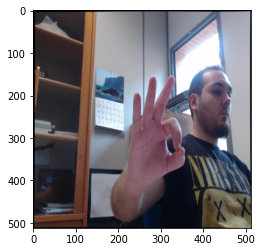

In [ ]:
i = 5

image_loc = jpg_records[i]
image = Reader.read_image(image_loc, shape=(512, 512), fix_color=True)

print(image.shape)

plt.imshow(image)
plt.show()

# Preprocessing

In [ ]:
def info_from_jpg_loc(a):

  a = os.path.splitext(a)[0].split('/')
  
  a1 = a[-2].split('_')[-1]
  a2 = a[-1].split('_')
  
  data_file_id = int(a1)

  frame = int(a2[0])
  dtype = a2[1]
  source_camera = int(a2[2])


  return data_file_id, frame, source_camera, dtype

In [ ]:
data = {'data_file_id':[], 'frame':[], 'source_camera':[], 'type': [], 'image_loc': []}

cols = list(data.keys())
_ = cols.pop()

for image_loc in jpg_records:
  
  data['image_loc'].append(image_loc)
  info = info_from_jpg_loc(image_loc)

  for key, value in zip(cols, info):

    data[key].append(value)

print(len(data['image_loc']) == len(jpg_records))

data = pd.DataFrame(data)
data.sort_values(by=['data_file_id', 'frame', 'source_camera'], inplace=True)
data.reset_index(drop=True, inplace=True)

True


In [ ]:
def info_from_txt_loc(a):

  a = os.path.splitext(a)[0].split('/')
  
  a1 = a[-2].split('_')[-1]
  a2 = a[-1].split('_')[0]
  
  data_file_id = int(a1)
  frame = int(a2)

  return data_file_id, frame

In [ ]:
joints_data = {'data_file_id':[], 'frame':[], 'txt_loc': []}

cols = list(joints_data.keys())
_ = cols.pop()

for txt_loc in txt_records:
  
  joints_data['txt_loc'].append(txt_loc)
  info = info_from_txt_loc(txt_loc)

  for key, value in zip(cols, info):

    joints_data[key].append(value)

print(len(joints_data['txt_loc']) == len(txt_records))

joints_data = pd.DataFrame(joints_data)
joints_data.sort_values(by=['data_file_id', 'frame'], inplace=True)

joints_data.reset_index(drop=True, inplace=True)

True


In [ ]:
merged_data = data.merge(joints_data, on=['data_file_id', 'frame'])

print(len(merged_data) == len(jpg_records))

True


In [ ]:
def read_joint_file(file_dir):

  return pd.read_csv(file_dir, sep=' ', header=None)

## Generate Annotations

`webcam:` Its the sample. A color image of a hand. <br>
`joints:` 3D joints positions in the real world coordinate frame.

In [ ]:
def getCameraMatrix(): # The camera intrinsic matrix - A, skew = 0

	Fx = 614.878
	Fy = 615.479
	Cx = 313.219
	Cy = 231.288

	cameraMatrix = np.array([[Fx, 0, Cx],
                           [0, Fy, Cy],
                           [0, 0, 1]])
                          
	return cameraMatrix


def getDistCoeffs(): # distortion coefficients

	return np.array([0.092701, -0.175877, -0.0035687, -0.00302299, 0])

In [ ]:
A = getCameraMatrix()
dist_coeffs = getDistCoeffs()

working_dir = './multiview_hand_pose/'
calibrations_dir = './multiview_hand_pose/calibrations'

SHAPE = (480, 640)
C_SHAPE = (*SHAPE, 3)

In [ ]:
def memoize_loaded_file(loader): 

  memory = {} 

  def inner(file_dir):

    if file_dir not in memory:
      
      memory[file_dir] = loader(file_dir)
    
    return memory[file_dir]
  
  return inner

def get_3d_points(file_dir): # 3D joints positions in the real world coordinate frame

  points3d = pd.read_csv(file_dir, sep=' ', header=None)
  points3d = points3d.iloc[0:21, 1:].values

  return points3d

def get_rvec_tvec(calibrations_dir: str, data_file_id: int, source_camera: int):
  
  @memoize_loaded_file
  def plk_load(file_dir):

    with open(file_dir, 'rb') as bin_buffer:

      return pickle.load(bin_buffer, encoding='latin1')

  main_dir = os.path.join(calibrations_dir, f'data_{data_file_id}', f'webcam_{source_camera}')

  rvec_dir =  os.path.join(main_dir, 'rvec.pkl')
  tvec_dir = os.path.join(main_dir, 'tvec.pkl')

  rvec = plk_load(rvec_dir)
  tvec = plk_load(tvec_dir)

  return rvec, tvec

def points3d_to_image_plane3d(joints_dir, calibrations_dir, data_file_id, source_camera, return_params=True):
  
  points3d_w = get_3d_points(joints_dir)
  rvec, tvec = get_rvec_tvec(calibrations_dir, data_file_id, source_camera)

  R, _ = cv2.Rodrigues(rvec)  
  points3d_c = np.zeros((len(points3d_w), 3), dtype='float32')

  for i in range(len(points3d_w)):

    p_c = R.T @ points3d_w[i][:, None] + tvec
    
    points3d_c[i] = p_c.squeeze()

  if return_params:

    return points3d_c, points3d_w, rvec, tvec

  else:

    return points3d_c
    
def points3d_to_image_plane2d(points3d_w, rvec, tvec, A, dist_coeffs):
  
  points2d_c, _ = cv2.projectPoints(points3d_w, rvec, tvec, A, dist_coeffs)
  points2d_c = points2d_c.squeeze()
  
  return points2d_c

In [ ]:
def get_all_transformations_ith(row_values):

  data_file_id, source_camera, txt_loc = row_values[[0, 2, 5]]
  
  points3d_c, points3d_w, rvec, tvec = points3d_to_image_plane3d(txt_loc, calibrations_dir, data_file_id, source_camera, return_params=True)
  points2d_c = points3d_to_image_plane2d(points3d_w, rvec, tvec, A, dist_coeffs)
  
  return points3d_c, points2d_c

In [ ]:
def get_all_transformations(df_values):

  points3d_c = np.zeros((len(df_values), 21, 3), dtype='float32')
  points2d_c = np.zeros((len(df_values), 21, 2), dtype='float32')
  
  for i in tqdm(range(len(df_values))):

    points3d_c[i], points2d_c[i] = get_all_transformations_ith(df_values[i])

  return points3d_c, points2d_c

In [ ]:
def fix_resized(points3d_c, points2d_c, resized_shape=None):

  scale_x, scale_y = 1, 1

  if resized_shape is not None:

    scale_x *= (resized_shape[1] / SHAPE[1])
    scale_y *= (resized_shape[0] / SHAPE[0])

  points2d_c[:, 0] *= scale_x
  points2d_c[:, 1] *= scale_y
  
  points3d_c[:, 0] *= scale_x
  points3d_c[:, 1] *= scale_y

  return points3d_c, points2d_c

### Generate Bounding Box

In [ ]:
def get_bbox_ith(points3d_c, points2d_c, ox_offset=0, oy_offset=0):

  min_x = points2d_c[:, 0].min()
  max_x = points2d_c[:, 0].max()

  min_y = points2d_c[:, 1].min()
  max_y = points2d_c[:, 1].max()

  centroid = points3d_c.mean(axis=0)

  offset =  centroid[2] * (30 / 390) # 30px / 390mm

  min_x = min_x - offset
  max_x = max_x + offset
  
  min_y = min_y - offset
  max_y = max_y + offset

  x = min_x + ox_offset
  y = min_y + oy_offset
  
  width  = max_x - min_x
  height = max_y - min_y 

  return x, y, width, height

In [ ]:
def plot_bbox(image, x, y, width, height, origin_radius=20):

  fig,ax = plt.subplots(1)

  ax.imshow(image)

  rect = patches.Rectangle((x, y), width, height, linewidth=1,edgecolor='r',facecolor='none')
  point = patches.Circle((x, y), radius=origin_radius)

  ax.add_patch(point)
  ax.add_patch(rect)
  
  plt.show()

In [ ]:
def plot_poses(image, points2d_c, radius=10):

  fig,ax = plt.subplots(1)

  ax.imshow(image)

  for p_c in points2d_c:
    
    point = patches.Circle(p_c, radius=radius)
    ax.add_patch(point)
  
  plt.show()

# Exploring Data

(480, 640, 3)


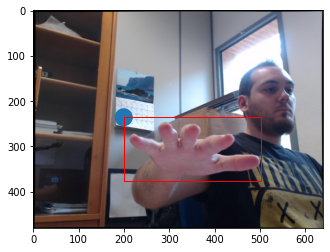

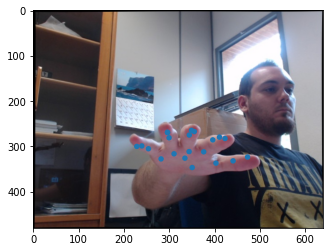

In [ ]:
i = 3
shape = None

sample_points3d_c, sample_points2d_c = get_all_transformations_ith(merged_data.values[i])
sample_points3d_c, sample_points2d_c = fix_resized(sample_points3d_c, sample_points2d_c, shape)

x, y, width, height = get_bbox_ith(sample_points3d_c, sample_points2d_c, 
                                   ox_offset=0, oy_offset=0)

image = Reader.read_image(merged_data.iloc[i]['image_loc'], shape=shape, fix_color=True)

print(image.shape)

plot_bbox(image, x, y, width, height, origin_radius=20)
plot_poses(image, sample_points2d_c, radius=6)

(256, 256, 3)


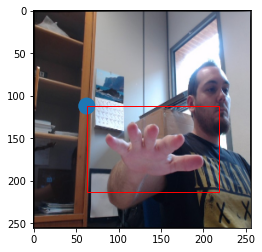

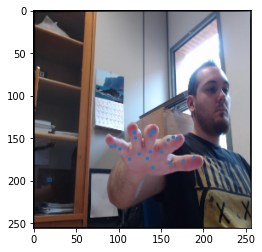

In [ ]:
i = 3
shape = (256, 256)

sample_points3d_c, sample_points2d_c = get_all_transformations_ith(merged_data.values[i])
sample_points3d_c, sample_points2d_c = fix_resized(sample_points3d_c, sample_points2d_c, shape)

x, y, width, height = get_bbox_ith(sample_points3d_c, sample_points2d_c, 
                                   ox_offset=0, oy_offset=0)

image = Reader.read_image(merged_data.iloc[i]['image_loc'], shape=shape, fix_color=True)

print(image.shape)

plot_bbox(image, x, y, width, height, origin_radius=10)
plot_poses(image, sample_points2d_c, radius=2)

# Write Annotations

In [ ]:
%%time

points3d_c, points2d_c = get_all_transformations(merged_data.values)


CPU times: user 4min 25s, sys: 8.92 s, total: 4min 34s
Wall time: 4min 51s


In [ ]:
poses_type = read_joint_file(txt_records[0]).iloc[:, 0].values[0:21, None]

In [ ]:
to_path = './poses_annotations'

if not os.path.exists(to_path):
  
  os.mkdir(to_path)

for i in tqdm(range(len(merged_data.values))):
  
  data_file_id, frame, source_camera = merged_data.values[i][[0, 1, 2]]

  path_3d = f'{to_path}/data_{data_file_id}/3d/'
  path_2d = f'{to_path}/data_{data_file_id}/2d/'
  
  filename = f'{frame}_webcam_{source_camera}.csv'

  if not os.path.exists(path_3d):

    os.makedirs(path_3d)
    os.makedirs(path_2d)

  
  values_3d = np.concatenate([poses_type, points3d_c[i]], axis=1)
  values_2d = np.concatenate([poses_type, points2d_c[i]], axis=1)

  ann3d_df = pd.DataFrame(data=values_3d, columns=['poses_type', 'x', 'y', 'z'])
  ann2d_df = pd.DataFrame(data=values_2d, columns=['poses_type', 'x', 'y'])

  ann3d_df.to_csv(path_3d + filename, encoding='utf-8', index=False)
  ann2d_df.to_csv(path_2d + filename, encoding='utf-8', index=False)

In [ ]:
!zip -r poses_annotations.zip /content/poses_annotations

# Annotations `metadata.csv`

In [ ]:
def filter_3d(row):

  dim = row.split('/')[-2]

  if dim == '2d':
    
    return None
  
  else:
    
    return row

def filter_2d(row):

  dim = row.split('/')[-2]
  
  if dim == '3d':
    
    return None
  
  else:
    
    return row

In [ ]:
def expand(row):

  row = row.values[0]

  rec = row.split('/')
  rec[-1] = os.path.splitext(rec[-1])[0]

  data_file_id = rec[-3].split('_')[-1]
  frame, _ , source_camera = rec[-1].split('_')
  
  return int(data_file_id), int(frame), int(source_camera), row

In [ ]:
cols = ['data_file_id' ,'frame', 'source_camera']
cols = {i: cols[i] for i in range(len(cols))}

csv_records = fdir.walk('./poses_annotations/', '.csv')

# filter (.csv) 2d, 3d

ann_3d = pd.DataFrame({'ann_3d_loc': csv_records})
ann_2d = pd.DataFrame({'ann_2d_loc': csv_records})

ann_3d['ann_3d_loc'] = ann_3d['ann_3d_loc'].apply(filter_3d)

ann_3d.dropna(inplace=True)
ann_3d.reset_index(drop=True, inplace=True)

ann_2d['ann_2d_loc'] = ann_2d['ann_2d_loc'].apply(filter_2d)

ann_2d.dropna(inplace=True)
ann_2d.reset_index(drop=True, inplace=True)

ann_2d = ann_2d.apply(expand, axis=1, result_type='expand')
ann_3d = ann_3d.apply(expand, axis=1, result_type='expand')

# rename columns

ann_3d.rename(columns=cols, inplace=True)
ann_2d.rename(columns=cols, inplace=True)

ann_3d.rename(columns={3: 'ann_3d_loc'}, inplace=True)
ann_2d.rename(columns={3: 'ann_2d_loc'}, inplace=True)

In [ ]:
ann_metadata = metadata.merge(ann_3d, on=list(cols.values()))
ann_metadata = ann_metadata.merge(ann_2d, on=list(cols.values()))

ann_metadata = ann_metadata.rename(columns={'txt_loc': 'real_world_joints_loc'})

In [ ]:
ann_metadata.to_csv('metadata.csv', encoding='utf-8', index=False)